# Load data

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker 
import pandas as pd

d  = 92
d_in_angstrom = d / 10

twoPlate_input_path = f'/Users/arghavan/lab/hp-results/gZ/raw_data/'
twoplate_file = f'{twoPlate_input_path}{d_in_angstrom}A.dat'

twoplate_df = pd.read_csv(twoplate_file, header=0, sep='\s+')

twoplate_x = twoplate_df['x(Angstrom)']
twoplate_numDens = twoplate_df['g_z(O)']


leftside_density_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-leftSide.dat'
rightside_density_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-rightSide.dat'

leftside_df = pd.read_csv(leftside_density_file, header=0, sep='\s+')
rightside_df = pd.read_csv(rightside_density_file, header=0, sep='\s+')

x_left = leftside_df['x(Angstrom)']
numDens_left = leftside_df['g_z(O)']

x_right = rightside_df['x(Angstrom)']
numDens_right = rightside_df['g_z(O)']

In [117]:
twoplate_x_centered = (twoplate_x - 25).round(2)

# ===========================================================================================================================
#                       shift the one-plate graphs to align with the start and end point of two-plate graph
# ===========================================================================================================================

x_left_shifted = (twoplate_x_centered.iloc[0] + (x_left - x_left.iloc[0])).round(2)
x_right_shifted = (twoplate_x_centered.iloc[-1] - (x_right.iloc[-1] - x_right)).round(2)


In [118]:
# ===========================================================================================================================
#          truncate the one-plate datasets to only include the region where they overlap with the two-plate dataset
# ===========================================================================================================================

x_min = np.min(twoplate_x_centered)
x_max = np.max(twoplate_x_centered)


# Truncate left dataset
mask_left = (x_left_shifted >= x_min) & (x_left_shifted <= x_max)
x_left_trimmed = x_left_shifted[mask_left]
numDens_left_trim = numDens_left[mask_left]

# Truncate right dataset
mask2 = (x_right_shifted >= x_min) & (x_right_shifted <= x_max)
x_right_trimmed = x_right_shifted[mask2]
numDens_right_trim = numDens_right[mask2]


In [ ]:
# ===========================================================================================================================
#                                         Interference of the two one-plate graphs
# ===========================================================================================================================

interference = numDens_left_trim.values + numDens_right_trim.values - 1
interference = np.clip(interference, a_min=0, a_max=None)

twoplate_numDens_vals = twoplate_numDens.values

# ===========================================================================================================================
#                 Truncatung data to only include the region where densities between the plates is non-zero
# ===========================================================================================================================


first_nonzero = np.argmax(twoplate_numDens_vals != 0)  # first index where twoplate_numDens != 0
last_nonzero = len(twoplate_numDens_vals) - np.argmax(twoplate_numDens_vals[::-1] != 0) - 1  # last index where twoplate_numDens != 0

n_keep_zeros = 4 # number of zeros to keep before the first non-zero

# compute starting index safely
start_idx = max(0, first_nonzero - n_keep_zeros)
end_idx = min(len(twoplate_numDens_vals), last_nonzero + n_keep_zeros + 1) 


mask = np.zeros_like(twoplate_numDens_vals, dtype=bool)
mask[start_idx:end_idx] = True  # only keep this region

x_left_trimmed_masked = x_left_trimmed[mask]
numDens_left_trim_masked = numDens_left_trim[mask]

x_right_trimmed_masked = x_right_trimmed[mask]
numDens_right_trim_masked = numDens_right_trim[mask]

interference_masked = interference[mask]

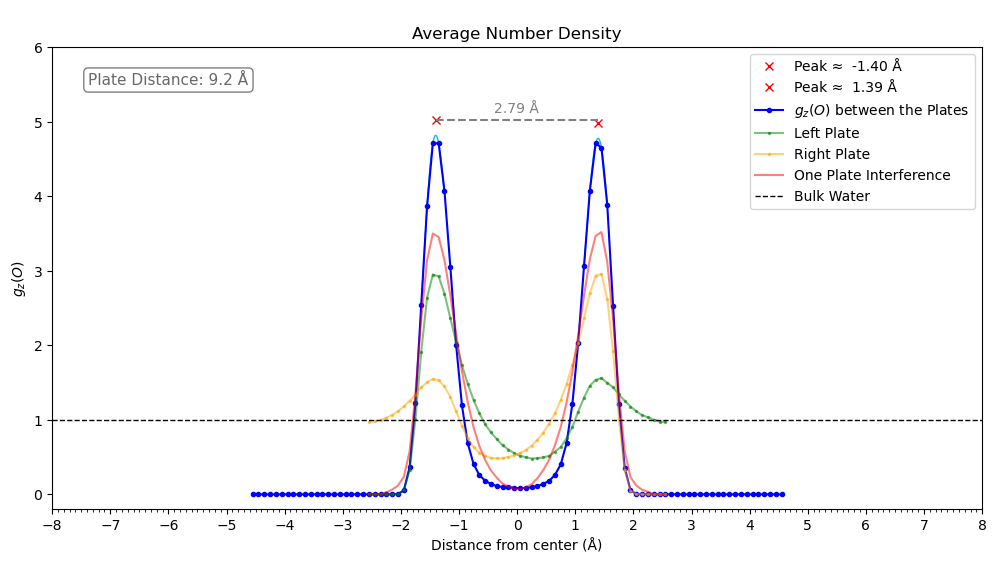

In [127]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
plt.figure(figsize=(12, 6))

# find raw peaks
peak_indices, _ = find_peaks(twoplate_numDens, height=1.2)                    # any maximum lower than 1.2 is not considered a peak (to avoid minimums and only look for peaks above bulk water level)
x_peaks_init = twoplate_x_centered[peak_indices]   


fitted_peaks = []


degree = 4

for x0_guess in x_peaks_init:
    
    # mask ±0.3 around initial peak guess
    mask = (twoplate_x_centered > x0_guess - 0.25) & (twoplate_x_centered < x0_guess + 0.25)
    x_fit = twoplate_x_centered[mask]
    y_fit = twoplate_numDens[mask]
    
    if len(x_fit) < degree + 1:
        continue
    coeffs = np.polyfit(x_fit, y_fit, deg=degree)
    poly = np.poly1d(coeffs)

    x_dense = np.linspace(x_fit.min(), x_fit.max(), 500)
    y_dense = poly(x_dense)
    max_idx = np.argmax(y_dense)
    x_peak = x_dense[max_idx]
    y_peak = y_dense[max_idx] 

    # saving peak info
    fitted_peaks.append((x_peak, y_peak))

    plt.plot(x_dense, y_dense, 'tab:cyan', linewidth = 1)
    plt.plot(x_peak, y_peak+0.2, 'rx', label=f'Peak ≈  {x_peak:.2f} Å')


# show the distance 
if len(fitted_peaks) >= 2:
    fitted_peaks.sort()  # sort by x
    x1, y1 = fitted_peaks[0]
    x2, y2 = fitted_peaks[1]
    y_line = max(y1, y2)
    plt.hlines(y=y_line+0.2, xmin=x1, xmax=x2, color='gray', linestyle='--')
    plt.text((x1 + x2) / 2, y_line + 0.3, f"{x2 - x1:.2f} Å", ha='center', fontsize=10, color='gray')

# ===========================================================================================================================
#                                                   Plotting
# ===========================================================================================================================




plt.plot(twoplate_x_centered, twoplate_numDens, 'bo-', markersize=3, label=r'$g_z(O)$ between the Plates')
plt.plot(x_left_trimmed_masked, numDens_left_trim_masked, label='Left Plate', marker='o', color='green',markersize='1.5', alpha=0.5)
plt.plot(x_right_trimmed_masked, numDens_right_trim_masked, label='Right Plate', marker='o', color='orange',markersize='1.5', alpha=0.5)
plt.plot(x_left_trimmed_masked, interference_masked, label='One Plate Interference', linestyle='-', color='red',markersize='1.5', alpha=0.5)


plt.hlines(y=1.00, xmin=-8, xmax=8, color='black', linestyle='--', linewidth=1, label='Bulk Water')

plt.text(-6, 5.5, f"Plate Distance: {d_in_angstrom} Å", ha='center', fontsize=11, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.title(f'\nAverage Number Density')
plt.xlabel('Distance from center (Å)')
plt.ylabel(r'$g_z(O)$')
plt.legend()
plt.ylim(-0.2, 6)
plt.xlim(-8,8)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))


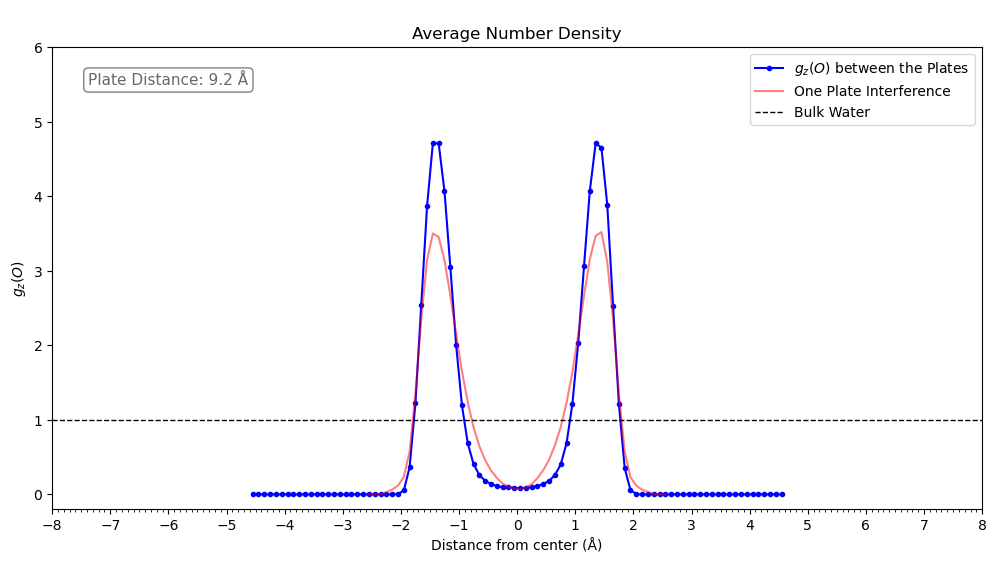

In [122]:
# ===========================================================================================================================
#                                                   Plotting
# ===========================================================================================================================


plt.figure(figsize=(12, 6))

plt.plot(twoplate_x_centered, twoplate_numDens, 'bo-', markersize=3, label=r'$g_z(O)$ between the Plates')
# plt.plot(x_left_trimmed_masked, numDens_left_trim_masked, label='Left Plate', marker='o', color='green',markersize='1.5', alpha=0.5)
# plt.plot(x_right_trimmed_masked, numDens_right_trim_masked, label='Right Plate', marker='o', color='orange',markersize='1.5', alpha=0.5)
plt.plot(x_left_trimmed_masked, interference_masked, label='One Plate Interference', linestyle='-', color='red',markersize='1.5', alpha=0.5)


plt.hlines(y=1.00, xmin=-8, xmax=8, color='black', linestyle='--', linewidth=1, label='Bulk Water')

plt.text(-6, 5.5, f"Plate Distance: {d_in_angstrom} Å", ha='center', fontsize=11, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.title(f'\nAverage Number Density')
plt.xlabel('Distance from center (Å)')
plt.ylabel(r'$g_z(O)$')
plt.legend()
plt.ylim(-0.2, 6)
plt.xlim(-8,8)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

In [113]:
twoplate_numDens_vals = twoplate_numDens.values

# indices of first and last non-zero values
first_nonzero = np.argmax(twoplate_numDens_vals != 0)  # first index where twoplate_numDens != 0
last_nonzero = len(twoplate_numDens_vals) - np.argmax(twoplate_numDens_vals[::-1] != 0) - 1  # last index

# number of zeros to keep before the first non-zero
n_keep_zeros = 4

# compute starting index safely
start_idx = max(0, first_nonzero - n_keep_zeros)
end_idx = min(len(twoplate_numDens_vals), last_nonzero + n_keep_zeros + 1) 


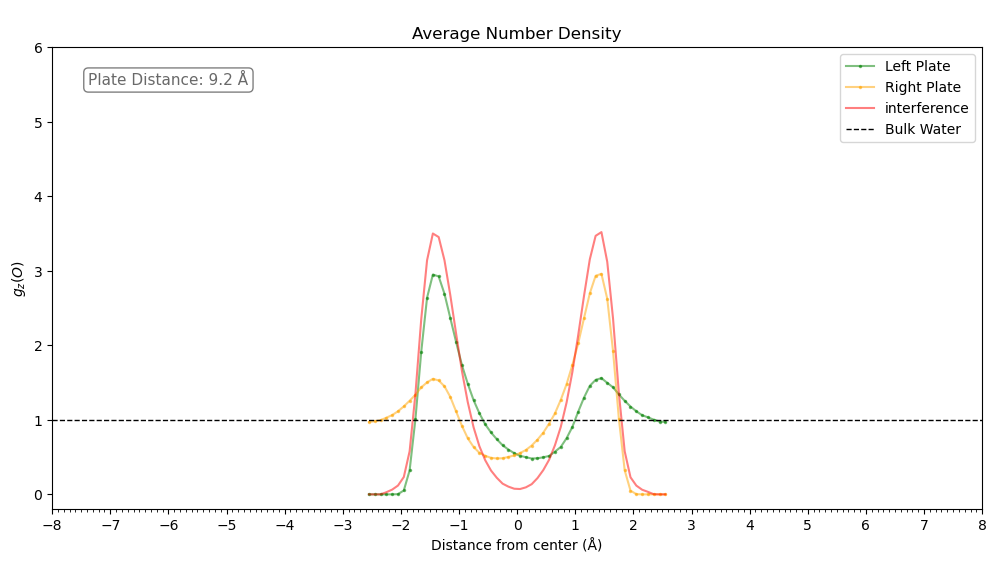

In [115]:
mask = np.zeros_like(twoplate_numDens_vals, dtype=bool)
mask[start_idx:end_idx] = True  # only keep this region

x_left_trimmed_masked = x_left_trimmed[mask]
numDens_left_trim_masked = numDens_left_trim[mask]

x_right_trimmed_masked = x_right_trimmed[mask]
numDens_right_trim_masked = numDens_right_trim[mask]

interference_masked = interference[mask]

plt.figure(figsize=(12, 6))

# plt.plot(twoplate_x_centered, twoplate_numDens, 'bo-', markersize=3, label=r'$g_z(O)$ between the Plates')
plt.plot(x_left_trimmed_masked, numDens_left_trim_masked, label='Left Plate', marker='o', color='green',markersize='1.5', alpha=0.5)
plt.plot(x_right_trimmed_masked, numDens_right_trim_masked, label='Right Plate', marker='o', color='orange',markersize='1.5', alpha=0.5)
plt.plot(x_left_trimmed_masked, interference_masked, label='interference', linestyle='-', color='red',markersize='1.5', alpha=0.5)


plt.hlines(y=1.00, xmin=-8, xmax=8, color='black', linestyle='--', linewidth=1, label='Bulk Water')

plt.text(-6, 5.5, f"Plate Distance: {d_in_angstrom} Å", ha='center', fontsize=11, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.title(f'\nAverage Number Density')
plt.xlabel('Distance from center (Å)')
plt.ylabel(r'$g_z(O)$')
plt.legend()
plt.ylim(-0.2, 6)
plt.xlim(-8,8)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))


# Reformatting